# Object Detection in Chest Xrays

This workshop uses a portion of the NIH Chest Xray dataset. Specifically, we will use about 1,000 images where we will predict the location of the trachea and throat of the patient.


---

In [8]:
# !pip install --upgrade pip
# !pip install matplotlib
# !pip install imageio
# !pip install --upgrade awscli
# !pip install --upgrade boto3
# !pip install sagemaker-experiments
# !pip install --upgrade sagemaker

     |████████████████████████████████| 307 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 750 kB/s  eta 0:00:01
Using legacy 'setup.py install' for sagemaker, since package 'wheel' is not installed.
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 0.1.2
    Uninstalling smdebug-rulesconfig-0.1.2:
      Successfully uninstalled smdebug-rulesconfig-0.1.2
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 1.50.17
    Uninstalling sagemaker-1.50.17:
      Successfully uninstalled sagemaker-1.50.17
    Running setup.py install for sagemaker ... done


## Enable SageMaker Experiments
First, let's create an experiment so we can track this job and all of our assets!

In [1]:
import boto3
import time
from smexperiments.experiment import Experiment

sm = boto3.client('sagemaker')

experiment_name = f"xray-object-detection-{int(time.time())}"
experiment = Experiment.create(experiment_name=experiment_name, 
                                    description="Training an object detection model on XRay data", 
                                    sagemaker_boto_client=sm)

Now you can open the Experiments tab on the lefthand side, and you should see a new experiment!

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
import itertools
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import sagemaker
from urllib.parse import urlparse

fids2bbs = defaultdict(list)

from ground_truth_od import group_miou
from ground_truth_od import BoundingBox, WorkerBoundingBox, \
    GroundTruthBox, BoxedImage

BUCKET = 'nih-xray-data'
PREFIX = 'curated-images'
EXP_NAME = 'nih-chest-xrays' #where to put experiment data

OUTPUT_MANIFEST_S3=f'{BUCKET}/{PREFIX}/output.manifest' #location of the manifest file in S3
IMAGE_DATA_S3=f'{BUCKET}/{PREFIX}' #location of image data in s3

print('S3 Location of Manifest File:')
print(OUTPUT_MANIFEST_S3)

print('S3 Location of Image Data:')
print(IMAGE_DATA_S3)


S3 Location of Manifest File:
nih-xray-data/curated-images/output.manifest
S3 Location of Image Data:
nih-xray-data/curated-images


---

# Process Manifest file and images
First we will load and preprocess the manifest file. This manifest file is in fact an **augmented manifest file**, and also contains the location of the throat of the patient in the xray

In [21]:
def read_data(file_name):
    !mkdir -p data #make a data directory if it does not exist
    with open(file_name, 'r') as f:
        output = [json.loads(line.strip()) for line in f.readlines()]

    return output

def write_manifest(file_name):
    f_out=open(file_name,'w')
    for i in output_clean:
        print(json.dumps(i),file=f_out,sep="\n")
    f_out.close()

def filter_manifest(file_name):
    'remove any images that are not labeled.'
    
    output = read_data(file_name)
    
    output_clean =[]
    
    metadata_info ='xray-labeling-job-clone-clone-full-clone-metadata' #change depending on the job
    
    for the_sample in output:
        z = the_sample[metadata_info]['creation-date']
        output_clean.append(the_sample)

    print(f'Number of images without errors {len(output_clean)}')
        
    return(output_clean)


output_clean = filter_manifest('output.manifest')
write_manifest('data/output_manifest_clean.manifest')

Number of images without errors 1099


In [22]:
def get_groundtruth_labels(output):
    # Create data arrays.
    img_uris = [None] * len(output)
    confidences = [None] * len(output)
    groundtruth_labels = [None] * len(output)
    human = np.zeros(len(output))

    # Find the job name contained within the manifest file manifest corresponds to.
    keys = list(output[0].keys())
    metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
    jobname = metakey[:-9]

    # Extract the data.
    for datum_id, datum in enumerate(output):
        img_uris[datum_id] = datum['source-ref']
        groundtruth_labels[datum_id] = str(datum[metakey]['class-map'])
        confidences[datum_id] = datum[metakey]['objects']
        human[datum_id] = int(datum[metakey]['human-annotated'] == 'yes')
    groundtruth_labels = np.array(groundtruth_labels)
    
    return groundtruth_labels

groundtruth_labels = get_groundtruth_labels(output_clean)

In [23]:
groundtruth_labels[0]

"{'0': 'Trachea'}"

In [31]:
def map_images_to_labels(output):

    # Create data arrays.
    confidences = np.zeros(len(output))

    # Find the job name the manifest corresponds to.
    keys = list(output[0].keys())
    metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
    jobname = metakey[:-9]
    output_images = []
    consolidated_boxes = []

    # Extract the data.
    for datum_id, datum in enumerate(output):
        image_size = datum[jobname]['image_size'][0]
        box_annotations = datum[jobname]['annotations']
        uri = datum['source-ref']
        box_confidences = datum[metakey]['objects']
        human = int(datum[metakey]['human-annotated'] == 'yes')

        # Make image object.
        image = BoxedImage(id=datum_id, size=image_size,
                           uri=uri)

        # Create bounding boxes for image.
        boxes = []
        for i, annotation in enumerate(box_annotations):
            box = BoundingBox(image_id=datum_id, boxdata=annotation)
            box.confidence = box_confidences[i]['confidence']
            box.image = image
            box.human = human
            boxes.append(box)
            consolidated_boxes.append(box)
        image.consolidated_boxes = boxes

        # Store if the image is human labeled.
        image.human = human

        # Retrieve ground truth boxes for the image.
        oid_boxes_data = fids2bbs[image.oid_id]
        gt_boxes = []
        for data in oid_boxes_data:
            gt_box = GroundTruthBox(image_id=datum_id, oiddata=data,
                                    image=image)
            gt_boxes.append(gt_box)
        image.gt_boxes = gt_boxes

        output_images.append(image)
        
    return output_images, jobname

output_images, jobname = map_images_to_labels(output_clean)

In [37]:
len(output_clean)

1099

In [55]:
def create_bounding_boxes(output_clean, output_images):
    # Iterate through the json files, creating bounding box objects.
    output_with_answers=[] #only include images with the answers in them
    output_images_with_answers=[]

    output_with_no_answers=[]
    output_images_with_no_answers=[]

    for i in range(0,len(output_clean)):
        try:
            #images with class_id have answers in them
            x = output_clean[i][jobname]['annotations'][0]['class_id']

            output_with_answers.append(output[i])
            output_images_with_answers.append(output_images[i])
        except:
            output_with_no_answers.append(output[i])
            output_images_with_no_answers.append(output_images[i])
            pass

        #add the box to the image
        for i in range(0,len(output_with_answers)):
            the_output=output_with_answers[i]
            the_image=output_images_with_answers[i]
            answers=the_output[jobname]['annotations']
            box=WorkerBoundingBox(image_id=i,boxdata=answers[0],worker_id='anon-worker')
            box.image=the_image
            the_image.worker_boxes.append(box)

    print(f"Number of images with labeled trachea/throat: {len(output_images_with_answers)}")
    print(f"Number of images without labeled trachea/throat: {len(output_with_no_answers)}")
    
    return output_with_answers
            
output_with_answers = create_bounding_boxes(output_clean, output_images)

Number of images with labeled trachea/throat: 851
Number of images without labeled trachea/throat: 248


In [53]:
def download_images(output_images_with_answers, image_dir = 'data', dataset_size = 5):
    image_subset = np.random.choice(output_images_with_answers, dataset_size, replace=False)

    for img in image_subset:
        target_fname = os.path.join(
            image_dir, img.uri.split('/')[-1])
        if not os.path.isfile(target_fname):
            !aws s3 cp {img.uri} {target_fname}
            
    return image_subset
        
image_subset = download_images(output_images_with_answers)

download: s3://nih-xray-data/curated-images/00000053_000.png to data/00000053_000.png
download: s3://nih-xray-data/curated-images/00000315_003.png to data/00000315_003.png
download: s3://nih-xray-data/curated-images/00000135_001.png to data/00000135_001.png
download: s3://nih-xray-data/curated-images/00000645_000.png to data/00000645_000.png
download: s3://nih-xray-data/curated-images/00000688_002.png to data/00000688_002.png


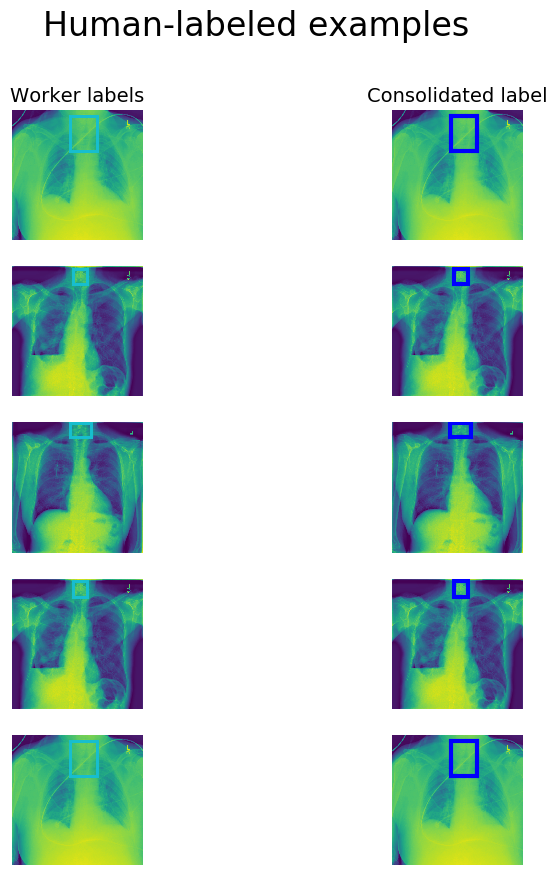

In [54]:
def visualize_images(image_subset, image_dir = 'data', n_show = 5):
    
    # Find human and auto-labeled images in the subset.
    human_labeled_subset = [img for img in image_subset if img.human]

    # Show examples of each
    fig, axes = plt.subplots(n_show, 2, figsize=(9, 2*n_show),
                             facecolor='white', dpi=100)
    fig.suptitle('Human-labeled examples', fontsize=24)
    axes[0, 0].set_title('Worker labels', fontsize=14)
    axes[0, 1].set_title('Consolidated label', fontsize=14)
    for row, img in enumerate(np.random.choice(human_labeled_subset, size=n_show)):
        img.download(image_dir)
        img.plot_worker_bbs(axes[row, 0])
        img.plot_consolidated_bbs(axes[row, 1])

visualize_images(image_subset)

(Note that in this context we only had one labeler, so the consolidated label will be identical to the worker label)

---

# Split Data and Copy to S3

In [57]:
def split_data(output):
    
    # Shuffle output in place.
    np.random.shuffle(output)

    dataset_size = len(output)
    train_test_split_index = round(dataset_size*0.9)

    train_data = output[:train_test_split_index]
    test_data = output[train_test_split_index:]

    train_test_split_index_2 = round(len(test_data)*0.5)
    validation_data=test_data[:train_test_split_index_2]
    hold_out=test_data[train_test_split_index_2:]
    
    return train_data, validation_data, hold_out
                   
train_data, validation_data, hold_out = split_data(output_with_answers)

In [58]:
def write_to_disk(train_data, validation_data, hold_out):
    num_training_samples = 0
    with open('data/train.manifest', 'w') as f:
        for line in train_data:
            f.write(json.dumps(line))
            f.write('\n')
            num_training_samples += 1

    with open('data/validation.manifest', 'w') as f:
        for line in validation_data:
            f.write(json.dumps(line))
            f.write('\n')
    with open('data/hold_out.manifest', 'w') as f:
        for line in hold_out:
            f.write(json.dumps(line))
            f.write('\n')
        
print(f'Training Data Set Size: {len(train_data)}')
print(f'Validatation Data Set Size: {len(validation_data)}')
print(f'Hold Out Data Set Size: {len(hold_out)}')

Training Data Set Size: 766
Validatation Data Set Size: 42
Hold Out Data Set Size: 43


In [59]:
def copy_to_s3(bucket, prefix, expr_name):
    !aws s3 cp data/train.manifest s3://{bucket}/{prefix}/{expr_name}/train.manifest
    !aws s3 cp data/validation.manifest s3://{bucket}/{prefix}/{expr_name}/validation.manifest
    !aws s3 cp data/hold_out.manifest s3://{bucket}/{prefix}/{expr_name}/hold_out.manifest
        
copy_to_s3(BUCKET, PREFIX, EXP_NAME)

upload: data/train.manifest to s3://nih-xray-data/curated-images/nih-chest-xrays/train.manifest
upload: data/validation.manifest to s3://nih-xray-data/curated-images/nih-chest-xrays/validation.manifest
upload: data/hold_out.manifest to s3://nih-xray-data/curated-images/nih-chest-xrays/hold_out.manifest


# Train on SageMaker & Track with Experiments

Let's create a trial within the experiment that we can associate this job with. 

In [3]:
from smexperiments.trial import Trial

trial_name = f"built-in-object-detection-{int(time.time())}"

trial = Trial.create(trial_name = trial_name,
                     experiment_name = experiment_name,
                     sagemaker_boto_client = sm)

In [62]:
import re
from sagemaker import get_execution_role
from time import gmtime, strftime

role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource('s3')

training_image = sagemaker.image_uris.retrieve('object-detection', boto3.Session().region_name, version='latest')
augmented_manifest_filename_train = 'train.manifest'
augmented_manifest_filename_validation = 'validation.manifest'
bucket_name = BUCKET
s3_prefix = EXP_NAME


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [4]:
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}/train.manifest'.format(BUCKET, PREFIX, EXP_NAME)
s3_validation_data_path = 's3://{}/{}/{}/validation.manifest'.format(BUCKET, PREFIX, EXP_NAME )
s3_debug_path = "s3://{}/{}/{}/debug-hook-data".format(BUCKET, PREFIX, EXP_NAME)
s3_output_path = f's3://{BUCKET}/{PREFIX}/{EXP_NAME}/output'

In [4]:

augmented_manifest_s3_key = s3_train_data_path.split(bucket_name)[1][1:]
s3_obj = s3.Object(bucket_name, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()['Body'].read().decode('utf-8')
augmented_manifest_lines = augmented_manifest.split('\n')
num_training_samples = len(augmented_manifest_lines) # Compute number of training samples for use in training job request.

# Determine the keys in the training manifest and exclude the meta data from the labling job.
attribute_names = list(json.loads(augmented_manifest_lines[0]).keys())
attribute_names = [attrib for attrib in attribute_names if 'meta' not in attrib]

In [84]:
# Create unique job name
job_name_prefix = EXP_NAME
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_job_name = job_name_prefix + timestamp

In [109]:
# Create unique job name
job_name_prefix = EXP_NAME
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_job_name = job_name_prefix + timestamp

training_params = \
    {
        "AlgorithmSpecification": {
            # NB. This is one of the named constants defined in the first cell.
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge", #Use a GPU backed instance
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": model_job_name,
        "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
            "base_network": "resnet-50",
            "use_pretrained_model": "1",
            "num_classes": "1",
            "mini_batch_size": "10",
            "epochs": "30",
            "learning_rate": "0.001",
            "lr_scheduler_step": "",
            "lr_scheduler_factor": "0.1",
            "optimizer": "sgd",
            "momentum": "0.9",
            "weight_decay": "0.0005",
            "overlap_threshold": "0.5",
            "nms_threshold": "0.45",
            "image_shape": "300",
            "label_width": "350",
            "num_training_samples": str(num_training_samples)
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400,
            "MaxWaitTimeInSeconds":259200,

        },
        "EnableManagedSpotTraining" :True,
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_train_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": attribute_names
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                        "S3Uri": s3_validation_data_path,
                        "S3DataDistributionType": "FullyReplicated",
                        # NB. This must correspond to the JSON field names in your augmented manifest.
                        "AttributeNames": attribute_names
                    }
                },
                "ContentType": "application/x-recordio",
                "RecordWrapperType": "RecordIO",
                "CompressionType": "None"
            }
        ],
        "ExperimentConfig": {
            'ExperimentName': experiment_name,
            'TrialName': trial_name,
            'TrialComponentDisplayName': 'Training'
            },
        "DebugHookConfig":{
            'S3OutputPath': s3_debug_path,
            'CollectionConfigurations': [
                {
                    'CollectionName': 'all_tensors',
                    'CollectionParameters': {
                        'include_regex': '.*',
                        "save_steps":"1, 2, 3"
                    }
                },
            ]
    },
    }

print('Training job name: {}'.format(model_job_name))
print('\nInput Data Location: {}'.format(
    training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))


Training job name: nih-chest-xrays-2020-10-15-23-48-42

Input Data Location: {'S3DataType': 'AugmentedManifestFile', 'S3Uri': 's3://nih-xray-data/curated-images/nih-chest-xrays/train.manifest', 'S3DataDistributionType': 'FullyReplicated', 'AttributeNames': ['source-ref', 'xray-labeling-job-clone-clone-full-clone']}


In [111]:
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=model_job_name)['TrainingJobStatus']
print(f'Training job name: {model_job_name}')
print('Training job current status: {}'.format(status))

Training job name: nih-chest-xrays-2020-10-15-23-48-42
Training job current status: InProgress


# Visualize Model with SageMaker Debugger
Now, we're going to use SageMaker Debugger to build a TensorPlot of our model!

![](images/tensorplot.gif)

In [115]:
!aws s3 sync {s3_debug_path} .

download: s3://nih-xray-data/curated-images/nih-chest-xrays/debug-hook-data/nih-chest-xrays-2020-10-15-23-48-42/debug-output/training_job_end.ts to nih-chest-xrays-2020-10-15-23-48-42/debug-output/training_job_end.ts


In [ ]:
import tensor_plot 

visualization = tensor_plot.TensorPlot(
    regex=".*relu_output", 
    path=folder_name,
    steps=10,  
    batch_sample_id=0,
    color_channel = 1,
    title="Relu outputs",
    label=".*sequential0_input_0",
    prediction=".*sequential0_output_0"
)

If we plot too many layers, it can crash the notebook. If you encounter performance or out of memory issues, then either try to reduce the layers to plot by changing the regex or run this Notebook in JupyterLab instead of Jupyter.

In the below cell we vizualize outputs of all layers, including final classification. Please note that because training job ran only for a few epochs classification accuracy is not high.

In [ ]:
visualization.fig.show(renderer="iframe")

---
# Bring your own Model and Train on SageMaker with Script Mode

In [118]:
from sagemaker.mxnet import MXNet
import sagemaker
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

role = sagemaker.get_execution_role()

ssd_estimator = MXNet(entry_point='ssd_entry_point.py',
                      source_dir = 'src',
                      role=role,
                      output_path=s3_output_path,
                      instance_count=1,
                      instance_type='ml.p3.8xlarge',
                      framework_version='1.6',
                      py_version='py3',
                      use_spot_instances=True,
                      max_wait = (8600*3),
                      max_run = 8600,
                      distribution={'parameter_server': {'enabled': True}},
                      hyperparameters={'epochs': 1, 'data-shape': 350},
                      debugger_hook_config = DebuggerHookConfig(
                      s3_output_path =  s3_debug_path,
                      collection_configs = [CollectionConfig(name='all_tensors',
                      parameters={'include_regex':'.*', 'save_steps':'1,2,3'})]))                     

ssd_estimator.fit(inputs = {'train': 's3://nih-xray-data/rec-files'}, 
                          experiment_config = {'ExperimentName': experiment_name,
                            'TrialName': trial_name, 'TrialComponentDisplayName': 'Training'})

INFO:sagemaker:Creating training-job with name: mxnet-training-2020-10-16-21-29-32-924


2020-10-16 21:29:33 Starting - Starting the training job...
2020-10-16 21:29:35 Starting - Launching requested ML instances......
2020-10-16 21:30:38 Starting - Preparing the instances for training......
2020-10-16 21:31:50 Downloading - Downloading input data...
2020-10-16 21:32:07 Training - Downloading the training image......
2020-10-16 21:33:20 Training - Training image download completed. Training in progress.2020-10-16 21:33:20,599 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2020-10-16 21:33:20,642 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"data-shape":350,"epochs":1}', 'SM_USER_ENTRY_POINT': 'ssd_entry_point.py', 'SM_FRAMEWORK_PARAMS': '{"sagemaker_parameter_server_enabled":true}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"train":{"RecordWrapp

UnexpectedStatusException: Error for Training job mxnet-training-2020-10-16-21-29-32-924: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/local/bin/python3.6 ssd_entry_point.py --data-shape 350 --epochs 1"

In [5]:
%%writefile src/requirements.txt

gluoncv

Overwriting src/requirements.txt


convert images to recordio
- https://github.com/aws/amazon-sagemaker-examples/blob/master/aws_sagemaker_studio/sagemaker_neo_compilation_jobs/gluoncv_ssd_mobilenet/gluoncv_ssd_mobilenet_neo_studio.ipynb

then point the manifest file to multiple rec files